In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# move into project directory
repo_name = "flower-fgvc"
%cd /content/drive/MyDrive/Personal-Projects/$repo_name
!ls

/content/drive/MyDrive/Personal-Projects/flower-fgvc
common	     data		datautils    Index.ipynb  models     run.yaml
config.yaml  data_processor.py	experiments  index.py	  README.md


In [3]:
# set up environment
# comment out if not required
'''
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib numpy pandas pyyaml opencv-python
'''

!pip install transformers


In [4]:
# this cell is for downloading data.
# as of yet data is not hosted and is available in the private data folder

#!tar xf data/102flowers.tgz -C data/

In [5]:
#set up some imports

import numpy as np
import torch
import random
from torchvision import transforms

# custom imports

from common.utils import init_config, get_exp_params, get_modelinfo
from datautils.dataset import FlowerDataset
from datautils.datareader import get_file_paths
from experiments.classification import Classification
from common.visualization import Visualization
from experiments.classifier_tester import ModelTester
from models.custom_models import get_model

In [6]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [7]:
config_params = init_config()
print('nb', config_params)

nb {'data_dir': '/content/drive/MyDrive/Personal-Projects/flower-fgvc/data', 'device': 'cuda', 'output_dir': '/content/drive/MyDrive/Personal-Projects/flower-fgvc/output', 'root_dir': '/content/drive/MyDrive/Personal-Projects/flower-fgvc', 'use_gpu': True}


In [8]:
# read experiment params

exp_params = get_exp_params()
print('Experiment parameters\n')
print(exp_params)

Experiment parameters

{'transform': {'resize_dim': 399, 'crop_dim': 300}, 'train': {'batch_size': 64, 'loss': 'ecc', 'epoch_interval': 1, 'num_epochs': 3, 'lamda1': 0.01, 'lamda2': 1.2, 'enable_lr_decay': False, 'lr_step': 10, 'lr_decay': 0.1, 'ecc_alpha': 0.5, 'shared_space_numfeats': 4096}, 'model': {'name': 'resnet18', 'optimizer': 'Adam', 'lr': 1e-05, 'weight_decay': 1e-05, 'amsgrad': True, 'momentum': 0.8, 'build_on_pretrained': False, 'pretrained_filename': '/models/checkpoints/last_model.pt'}, 'dataset': {'size': 'subset'}}


In [9]:
composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        #std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])

train_fns, val_fns, test_fns, _ = get_file_paths(config_params['data_dir'])
ftr_dataset = FlowerDataset(config_params['data_dir'], train_fns, composed_transforms)
val_dataset = FlowerDataset(config_params['data_dir'], val_fns, composed_transforms)
test_dataset = FlowerDataset(config_params['data_dir'], test_fns, composed_transforms)
sm_trlen = int(0.3 * len(ftr_dataset))
sm_telen = int(0.03 * len(test_dataset))
sm_vlen = int(0.3 * len(val_dataset))

sm_ftr_dataset = torch.utils.data.Subset(ftr_dataset, list(range(sm_trlen)))
sm_val_dataset = torch.utils.data.Subset(val_dataset, list(range(sm_vlen)))
sm_test_dataset = torch.utils.data.Subset(test_dataset, list(range(sm_telen)))

print('Full train dataset length', len(ftr_dataset))
print('Subset train dataset length', sm_trlen)
print('\nFull validation dataset length', len(val_dataset))
print('Subset validation dataset length', sm_vlen)
print('\nFull test dataset length', len(test_dataset))
print('Subset test dataset length', sm_telen)

Full train dataset length 1020
Subset train dataset length 306

Full validation dataset length 1020
Subset validation dataset length 306

Full test dataset length 6149
Subset test dataset length 184


In [10]:

from models.custom_models import get_model
import torch
from common.utils import get_exp_params, get_config, save_experiment_output, save_model_helpers, save_model_chkpt, get_saved_model, get_modelinfo
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
from common.loss_utils import ECCLoss
from transformers import CLIPProcessor, CLIPModel
from torch.optim.lr_scheduler import StepLR

class Classification:

    def __init__(self, train_dataset, val_dataset):
        cfg = get_config()
        self.data_dir = cfg['data_dir']
        self.root_dir = cfg['root_dir']
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        #self.test_dataset = test_dataset
        self.exp_params = get_exp_params()
        self.model_params = self.exp_params['model']
        self.device = cfg['device']
        self.num_classes = 102
        self.lamda1 = self.exp_params['train']['lamda1']
        self.lamda2 = self.exp_params['train']['lamda2']
        self.dim = 0
        #self.data_transform = transforms

    def __loss_fn(self, loss_name = 'cross-entropy'):
        if loss_name == 'cross-entropy':
            return torch.nn.CrossEntropyLoss()
        elif loss_name == 'mse':
            return torch.nn.MSELoss()
        elif loss_name == 'l1':
            return torch.nn.L1Loss()
        elif loss_name == 'ecc':
            loss_fn = ECCLoss(self.num_classes, self.dim)
            return loss_fn
        else:
            raise SystemExit("Error: no valid loss function name passed! Check run.yaml")

    def __save_model_checkpoint(self, model_state, chkpt_info, is_chkpoint = True):
        save_experiment_output(model_state, chkpt_info, is_chkpoint)
        #os.remove(os.path.join(self.root_dir, "models/checkpoints/current_model.pt"))

    def __get_clip_features4classes(self):
        model_name = "openai/clip-vit-base-patch32"  # You can choose other available models
        num_text_feats = 512
        model = CLIPModel.from_pretrained(model_name)
        processor = CLIPProcessor.from_pretrained(model_name)
        lines = []
        with open(os.path.join(self.data_dir, 'processed_class_descriptions.txt')) as fp:
            lines = fp.readlines()
        text_features = torch.zeros(self.num_classes, num_text_feats)
        for i, line in enumerate(lines):
            desc = line.split(" : ")[1]
            inputs = processor(text=desc, return_tensors="pt", padding=True)
            with torch.no_grad():
                outputs = model.get_text_features(**inputs)
            outputs = outputs / outputs.norm(p = 2, dim = -1, keepdim = True)
            outputs = outputs.cpu()
            text_features[i] = outputs
        return text_features



    def __conduct_training(self, model, optimizer, train_loader, val_loader,
        tr_len, val_len, model_info = None):
        num_epochs = self.exp_params['train']['num_epochs']
        epoch_interval = self.exp_params['train']['epoch_interval']

        if model_info == None:
            trlosshistory, vallosshistory, valacchistory = [], [], []
            epoch_arr = list(range(0, num_epochs))
        else:
            trlosshistory = model_info['trlosshistory']
            vallosshistory = model_info['vallosshistory']
            valacchistory =  model_info['valacchistory']
            last_epoch = model_info['last_epoch']
            epoch_arr = list(range(last_epoch + 1, num_epochs))

        self.text_features = self.__get_clip_features4classes().to(self.device)
        ce_loss_fn = self.__loss_fn()
        loss_fn = self.__loss_fn(self.exp_params['train']['loss'])
        #print('text features size', self.text_features.size(), '\n')
        scheduler = StepLR(optimizer,
            step_size = self.exp_params['train']['lr_step'],
            gamma = self.exp_params['train']['lr_decay'])

        for ei, epoch in enumerate(epoch_arr):
            model.train()
            tr_loss, val_loss, val_acc = 0.0, 0.0, 0.0
            ratio = (epoch + 1) / num_epochs

            for _, batch in enumerate(tqdm(train_loader, desc = '\t\tRunning through training set', position = 0, leave = True, disable = True)):
                optimizer.zero_grad()
                imgs = batch['img'].float().to(self.device)
                olabels = batch['olabel'].to(self.device)
                lbls = batch['label'].type(torch.LongTensor).to(self.device)
                op,feats = model(imgs)
                #print('op sz', op.size(), olabels.size(), batch['label'].size(), feats.size())
                celoss = ce_loss_fn(op, lbls) * imgs.size(0)
                mcc, clg, _, _ = loss_fn(feats, op, lbls)
                loss = celoss + (ratio * self.lamda1 * mcc) + (ratio * self.lamda2 * clg)
                loss.backward()
                optimizer.step()
                tr_loss += loss.item()
            if self.exp_params['train']['enable_lr_decay']:
                scheduler.step()

            tr_loss /= tr_len
            trlosshistory.append(tr_loss)

            model.eval()

            for _, batch in enumerate(tqdm(val_loader, desc = '\t\tRunning through validation set', position = 0, leave = True, disable = True)):
                imgs = batch['img'].float().to(self.device)
                olabels = batch['olabel'].to(self.device)
                lbls = batch['label'].type(torch.LongTensor).to(self.device)
                op, feats = model(imgs)
                celoss = ce_loss_fn(op, lbls) * imgs.size(0)
                mcc, clg, _, _ = loss_fn(feats, op, lbls)
                loss = celoss + (self.lamda1 * mcc * ratio) + (self.lamda2 * clg * ratio)
                #loss = loss_fn(op, olabels)
                val_loss += loss.item()
                pred_label = torch.argmax(op, 1)
                #print('label size', correct_label.size(), pred_label.size())
                val_acc += (lbls == pred_label).sum()

            val_loss /= val_len
            val_acc /=  val_len
            vallosshistory.append(val_loss)
            valacchistory.append(val_acc.item())

            if epoch % epoch_interval == 0 or ei == 0:
                print(f'\tEpoch {epoch} Training Loss: {tr_loss}')
                print(f"\tEpoch {epoch} Validation Loss: {val_loss}\n")

            model_info = {
                'trlosshistory': trlosshistory,
                'vallosshistory': vallosshistory,
                'valacchistory': valacchistory,
                'last_epoch': epoch
            }

            self.__save_model_checkpoint(
                model,
                model_info
            )

        model_info = {
            'trlosshistory': trlosshistory,
            'vallosshistory': vallosshistory,
            'valacchistory': valacchistory,
            'last_epoch': -1
        }
        self.__save_model_checkpoint(model, model_info, False)

    def __get_model(self, model_name):
        model = get_model(102, model_name)
        model_chkpt_path = os.path.join(self.root_dir, 'models/checkpoints/curr_model.pt')
        print('model chkpt path', model_chkpt_path)
        if os.path.exists(model_chkpt_path):
            print('Loading saved model...')
            model = get_saved_model(model, True)
            model_info = get_modelinfo(True)
            return model, model_info
        return model, None


    def run_fgvc_pipeline(self):
        model_name = self.model_params['name']
        model, model_info = self.__get_model(model_name)
        self.dim = model.dim
        optimizer = torch.optim.Adam(model.parameters(),
            lr = self.model_params['lr'],
            weight_decay = self.model_params['weight_decay'],
            amsgrad = self.model_params['amsgrad'])
        batch_size = self.exp_params['train']['batch_size']

        train_loader = DataLoader(self.train_dataset, batch_size = batch_size, shuffle = False)
        val_loader = DataLoader(self.val_dataset, batch_size = batch_size, shuffle = False)
        tr_len = len(self.train_dataset)
        val_len = len(self.val_dataset)

        print('Training of classifier...\n')

        self.__conduct_training(model, optimizer, train_loader, val_loader, tr_len, val_len, model_info)

        torch.cuda.empty_cache()





In [ ]:
# cell that trains the model
composed_transforms =  transforms.Compose([
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]),
            transforms.Resize(exp_params['transform']['resize_dim']),
            transforms.CenterCrop(exp_params['transform']['crop_dim'])
        ])
if exp_params['dataset']['size'] == 'subset':
    classification = Classification(sm_ftr_dataset, sm_val_dataset)
    classification.run_fgvc_pipeline()
else:
    classification = Classification(ftr_dataset, val_dataset)
    classification.run_fgvc_pipeline()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.5MB/s]


model chkpt path /content/drive/MyDrive/Personal-Projects/flower-fgvc/models/checkpoints/curr_model.pt
Training of classifier...



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


	Epoch 0 Training Loss: 4.7766431920668655
	Epoch 0 Validation Loss: 4.783351723664726

	Epoch 1 Training Loss: 4.779813380023233
	Epoch 1 Validation Loss: 4.8587274987713185

	Epoch 2 Training Loss: 4.793160482169756
	Epoch 2 Validation Loss: 4.91280853670407




Model results




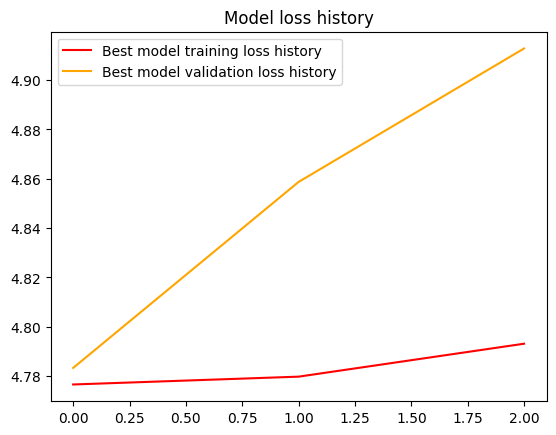

In [ ]:
model_info = get_modelinfo('')
vis = Visualization(model_info)
vis.get_results()

In [ ]:
# cell that tests the model
model = get_model(102, exp_params["model"]["name"])
model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.device(config_params["device"])))

if exp_params['dataset']['size'] == 'subset':
    mt = ModelTester(model, sm_test_dataset, composed_transforms)
    mt.test_and_plot()
else:
    mt = ModelTester(model, sm_test_dataset, composed_transforms)
    mt.test_and_plot()

<ipython-input-13-d1cd05556ef8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/checkpoints/last_model.pt", map_location = torch.de


Test Loss: 1.5432981961015342
Test Accuracy: tensor(0.1141, device='cuda:0') 

